# Mining the data #

In [70]:
import requests
import pprint
import json
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook
import pickle
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

We will use the OpenDota API; each call gives a sample of 100 matches below a specified MatchID. After filtering for high mmr, we get 20-40 matches per call. Use one-hot-encoding to convert these to a numpy array (1s where the hero is picked, 0s elsewhere):

First get the hero dictionary:

In [19]:
h = requests.get("https://api.opendota.com/api/heroes").json()
hero_df = pd.DataFrame(h)
hero_df = hero_df.drop(hero_df.index[-1])

In [4]:
def pickaxe(below_match_id = None):
    # Pick out relevant matches from a sample of 100
    over4k = []
    if below_match_id == None:
        string = 'https://api.opendota.com/api/publicMatches'
    else:
        string = 'https://api.opendota.com/api/publicMatches?less_than_match_id=' + str(below_match_id)
    try:
        A = requests.get(string).json()
    except: return over4k, below_match_id
    
    for i in range(len(A)):
        try:
            if A[i].get('avg_mmr', None) is not None:
                if A[i]['game_mode'] == 22 and A[i]['avg_mmr'] > 4000:
                    over4k.append(A[i])
        except: return over4k, below_match_id
    lowest_match_id = A[-1]['match_id']
    return over4k, lowest_match_id

def picked_heroes(hero_string):
    # Convert the string from pickaxe() to a length 116 array with 1s on picked heroes, 0 elsewhere.
    team_input = np.zeros(len(hero_df))
    y = [int(i) for i in hero_string.split(',')]
    for item in y:
        idx = int(hero_df[hero_df['id'] == item].index[0])
        team_input[idx] += 1
    return team_input

def process_the_pickaxe(game_list):
    Xt = np.zeros(232)
    yt = np.array(0)
    for item in game_list:
        X = np.hstack((picked_heroes(item['radiant_team']), picked_heroes(item['dire_team'])))
        y = np.array(0)
        y += item['radiant_win']*1
        Xt = np.vstack((Xt,X))
        yt = np.vstack((yt,y))
    Xt = np.delete(Xt, 0, 0)
    yt = np.delete(yt, 0, 0)
    if Xt.shape == (231,):
        Xt = None
        yt = None
    return Xt, yt

def single_call(last_match_id = None):
    # Perform a call for 100 matches and process it.
    if last_match_id == None:
        a,c = pickaxe()
    else:
        a,c = pickaxe(last_match_id)
    X_4, y_4 = process_the_pickaxe(a)
    return X_4, y_4, c

def multiple_calls(call_number = 60, last_match_id = None):
    Total_X_4 = np.zeros(232)
    Total_y_4 = np.array(0)
    for i in tqdm_notebook(range(call_number)):
        time.sleep(1)
        X_4, y_4, last_match_id = single_call(last_match_id = last_match_id)
        if X_4 is not None:
            Total_X_4 = np.vstack((Total_X_4, X_4))
            Total_y_4 = np.vstack((Total_y_4, y_4))
    Total_X_4 = np.delete(Total_X_4, 0, 0)
    Total_y_4 = np.delete(Total_y_4, 0, 0)
    return Total_X_4, Total_y_4, last_match_id

def import_the_data():
    infile = open('X_big_cat_2','rb')
    X = pickle.load(infile)
    infile.close()
    infile = open('y_big','rb')
    y = pickle.load(infile)
    infile.close()
    return X,y

def save_data(X,X_name):
    filename = X_name
    outfile = open(filename,'wb')
    pickle.dump(X,outfile)
    outfile.close()

In [7]:
X, y, match_id = multiple_calls(call_number = 18000, last_match_id=None)

C:\Users\Gintas\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: in the future the special handling of scalars will be removed from delete and raise an error


Convert to sparse matrix to save space, and save onto pickled files:

In [ ]:
X = csr_matrix(X)
save_data(X,'X_total')
save_data(y,'y_total')

## Preliminary data analysis

Let's consider the hero winrate and hero pickrate distributions. For the purpose of feature engineering, we will restrict to the training set (exclude validation/test sets).

In [12]:
X,y = import_the_data()
X = X.toarray()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print('X_train shape:', X_train.shape)
X,y = X_train, y_train

X_train shape: (106720, 260)


In [13]:
def winrate_and_popularity(idx):
    # Given the index 0-116, output the winrate and number of games played
    wins = 0
    losses = 0
    for i in range(X.shape[0]):
        if X[i,idx] == 1 and y[i] == 1:
            wins += 1
        if X[i,idx] == 1 and y[i] == 0:
            losses += 1
        if X[i,idx+116] == 1 and y[i] == 1:
            losses += 1
        if X[i,idx+116] == 1 and y[i] == 0:
            wins += 1
    winrate = wins / (wins + losses)
    total_games = wins + losses
    return winrate, total_games

In [20]:
winrates = []
games = []

for i in tqdm_notebook(range(len(hero_df))):
    winrate, total_games = winrate_and_popularity(i)
    winrates.append(winrate)
    games.append(total_games)

In [49]:
# Add hero winrates and pickrates to the hero dictionary

hero_df['winrate'] = pd.Series(winrates)
hero_df['pickrate'] = pd.Series(games)
hero_df['pickrate'] /= X.shape[0]

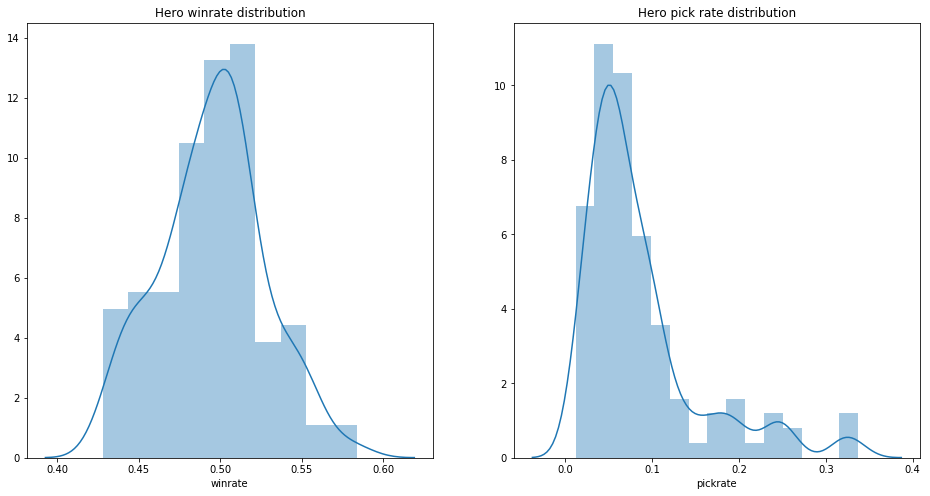

In [99]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.distplot(hero_df['winrate'])
plt.title('Hero winrate distribution')
plt.subplot(1,2,2)
sns.distplot(hero_df['pickrate'])
plt.title('Hero pick rate distribution');

We will build our features to emphasise outliers visible above: both tails of the gaussian hero winrate as well as the most frequently picked heroes. Let's look at them more closely:

In [50]:
least_winrates = hero_df.sort_values(by = ['winrate'], ascending = False)[['localized_name', 'winrate']].tail(10)
top_winrates = hero_df.sort_values(by = ['winrate'], ascending = False)[['localized_name', 'winrate']].head(10)
top_popularity = hero_df.sort_values(by = ['pickrate'], ascending = False)[['localized_name', 'pickrate']].head(10)

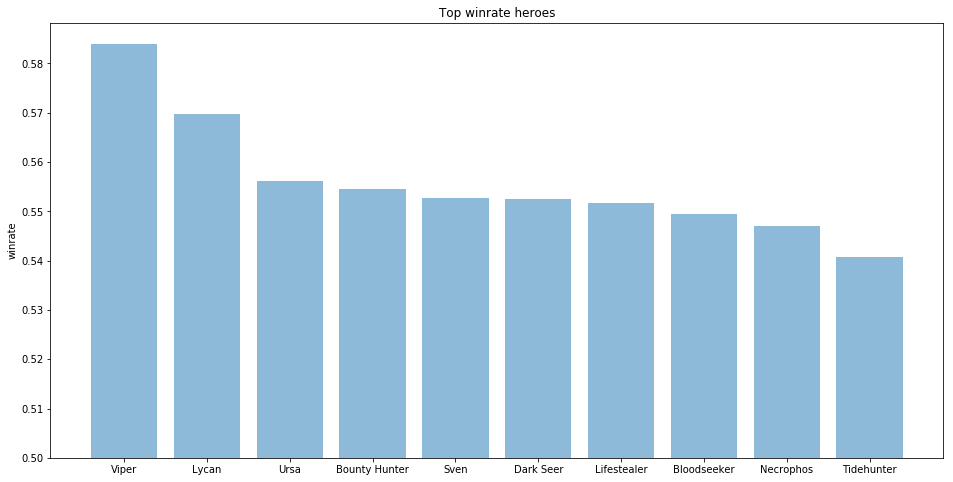

In [102]:
plt.figure(figsize = (16,8))
plt.title('Top winrate heroes')
y_pos = np.arange(10)
plt.bar(y_pos, top_winrates['winrate']-0.5, align='center',  bottom = 0.5, alpha = 0.5)
plt.xticks(y_pos, top_winrates['localized_name'])
plt.ylabel('winrate');

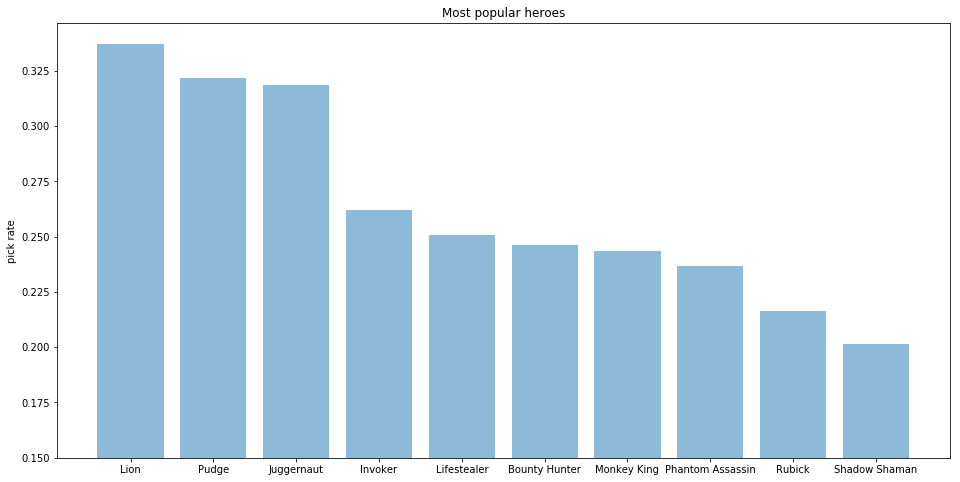

In [104]:
plt.figure(figsize = (16,8))
plt.title('Most popular heroes')
y_pos = np.arange(10)
plt.bar(y_pos, top_popularity['pickrate']- 0.15, align='center', alpha = 0.5, bottom  = 0.15)
plt.xticks(y_pos, top_popularity['localized_name'])
plt.ylabel('pick rate');

# Feature engineering##

## 1) More information about the heroes

Aside from passing the one-hot-encoded hero picks, it's a good idea to let the model know how many carries / supports the team has in total (a balanced combination should yield higher winrates that too many carries or too many supports). Use the hero dictionary, which stores the hero roles, to get the total carry/support numbers and append them to the one-hot array. 

While we're at it, we will pass the total agi/str/int hero count, as well as the melee/range count.

In [15]:
X,y = import_the_data()

In [12]:
X = csr_matrix(X)

In [6]:
hero_df[['localized_name','roles','primary_attr', 'attack_type']].head()

,localized_name,roles,primary_attr,attack_type
0,Anti-Mage,"[Carry, Escape, Nuker]",agi,Melee
1,Axe,"[Initiator, Durable, Disabler, Jungler]",str,Melee
2,Bane,"[Support, Disabler, Nuker, Durable]",int,Ranged
3,Bloodseeker,"[Carry, Disabler, Jungler, Nuker, Initiator]",agi,Melee
4,Crystal Maiden,"[Support, Disabler, Nuker, Jungler]",int,Ranged


In [7]:
hero_roles = []
for i in range(len(hero_df)):
    hero_roles.extend(hero_df['roles'][i])
roles = list(dict.fromkeys(hero_roles))
attributes = ['agi', 'str', 'int']
attack_types = ['Melee', 'Ranged']

In [8]:
def add_categoricals(X): 
    X_attribute = np.zeros((X.shape[0], len(attributes)))
    X_attack_types = np.zeros((X.shape[0], len(attack_types)))
    X_roles = np.zeros((X.shape[0], len(roles)))
    for i in tqdm_notebook(range(X.shape[0])):
        for j in range(116):
            if X[i,j] == 1:
                for item in hero_df.iloc[j]['roles']:
                    idx = roles.index(item)
                    X_roles[idx] += 1
                attribute = hero_df.iloc[j]['primary_attr']
                X_attribute[i,attributes.index(attribute)] += 1
                attack_type = hero_df.iloc[j]['attack_type']
                X_attack_types[i,attack_types.index(attack_type)] += 1
    radiant_cats = np.hstack((X_roles, X_attribute, X_attack_types))
    
    X_attribute = np.zeros((X.shape[0], len(attributes)))
    X_attack_types = np.zeros((X.shape[0], len(attack_types)))
    X_roles = np.zeros((X.shape[0], len(roles)))
    for i in tqdm_notebook(range(X.shape[0])):
        for j in range(116):
            if X[i,j+116] == 1:
                for item in hero_df.iloc[j]['roles']:
                    idx = roles.index(item)
                    X_roles[idx] += 1
                attribute = hero_df.iloc[j]['primary_attr']
                X_attribute[i,attributes.index(attribute)] += 1
                attack_type = hero_df.iloc[j]['attack_type']
                X_attack_types[i,attack_types.index(attack_type)] += 1
    dire_cats = np.hstack((X_roles, X_attribute, X_attack_types))
    radiant_cats = csr_matrix(radiant_cats)
    dire_cats = csr_matrix(dire_cats)
    X_appended = csr_matrix(hstack((X,radiant_cats, dire_cats)))
    
    
    return X_appended

In [ ]:
cat_X = add_categoricals(X)
print(cat_X.shape)

In [21]:
save_data(cat_X,'X_big_cat_2')
save_data(y,'y_big_cat')